In [3]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# import skimage.io as io
import random
from torch_geometric.data import Data
os.chdir('/public/home/jijh/diffusion_project/ADiffusion')
import importlib
import src.preprocessing.data_process
importlib.reload(src.preprocessing.data_process)
from src.preprocessing.data_process import extract_patches, create_graph_data_dict, construct_affinity_matrix

In [4]:
def seed_everything(seed=0):
    """Initialize random seeds for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
# Set random seed for reproducibility
random_seed = 0
seed_everything(random_seed)

# Data Preprocessing

In [5]:

file_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/"  # Directory containing the data files
files = os.listdir(file_dir)  # List all files in the directory
files = [i for i in files if i.endswith(".h5ad") and "month" in i]  # Filter files to include only those ending with ".h5ad" and containing "month"
file_paths = [os.path.join(file_dir, i) for i in files]  # Create full file paths for the filtered files
adatas = {}  # Initialize an empty dictionary to store AnnData objects

# Read each file and store the AnnData object in the dictionary
for i in range(len(file_paths)):
    adatas[files[i].split(".")[0]] = sc.read(file_paths[i])

In [6]:
from tqdm import tqdm

file_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/"  # Directory containing the data files
files = os.listdir(file_dir)  # List all files in the directory
files = [i for i in files if i.endswith(".h5ad") and "month" in i]  # Filter files to include only those ending with ".h5ad" and containing "month"
file_paths = [os.path.join(file_dir, i) for i in files]  # Create full file paths for the filtered files
adatas = {}  # Initialize an empty dictionary to store AnnData objects

# Read each file and store the AnnData object in the dictionary
for i in range(len(file_paths)):
    adatas[files[i].split(".")[0]] = sc.read(file_paths[i])

# Preprocess each AnnData object
for key in tqdm(adatas.keys(), desc="Preprocessing datasets"):
    sc.pp.normalize_total(adatas[key], target_sum=1e4)  # Normalize counts per cell
    sc.pp.log1p(adatas[key])  # Logarithmize the data
    adatas[key].layers["raw"] = adatas[key].X.copy()  # Store the raw data in the "raw" layer
    sc.pp.scale(adatas[key], max_value=10)  # Scale the data to have a maximum value of 10
    sc.tl.pca(adatas[key], svd_solver="arpack")  # Perform PCA

Preprocessing datasets: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


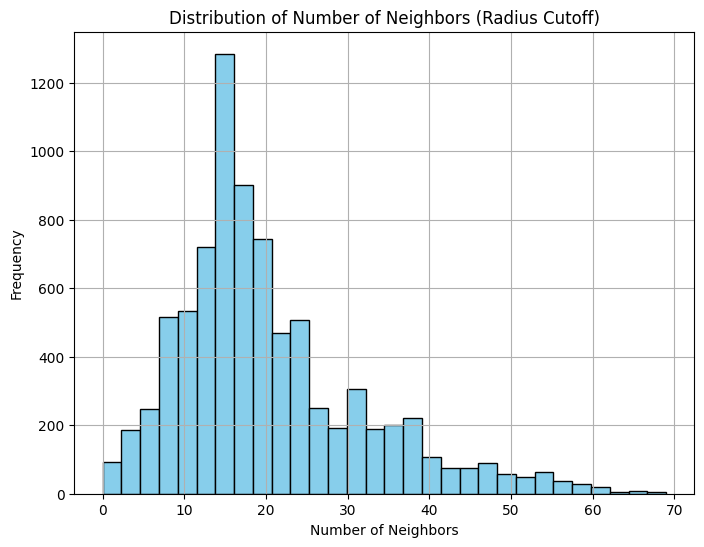

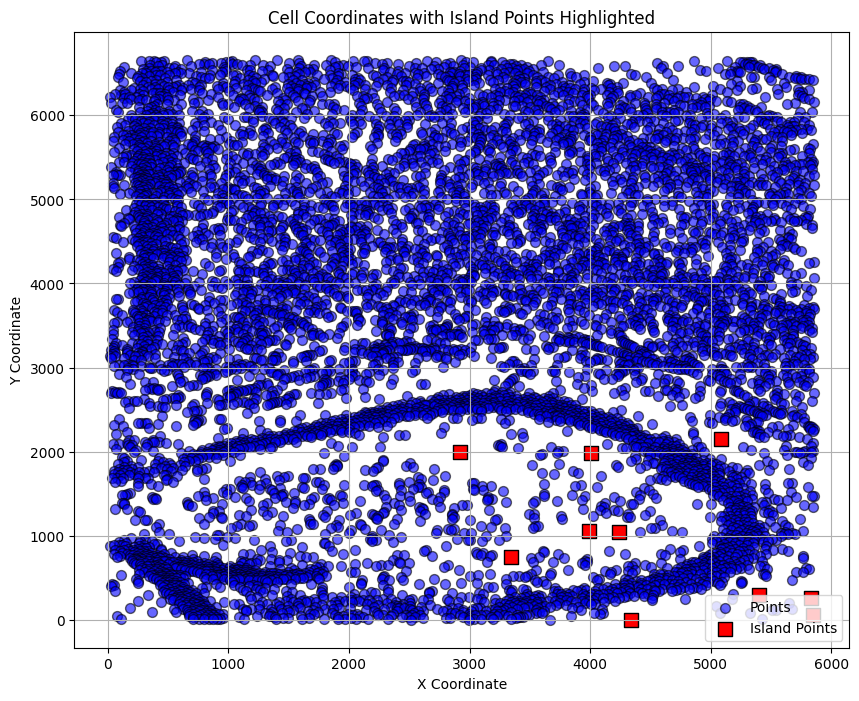

Number of island points: 10
Island point indices: [6068 6224 6239 6894 6901 7122 7792 7836 8110 8179]


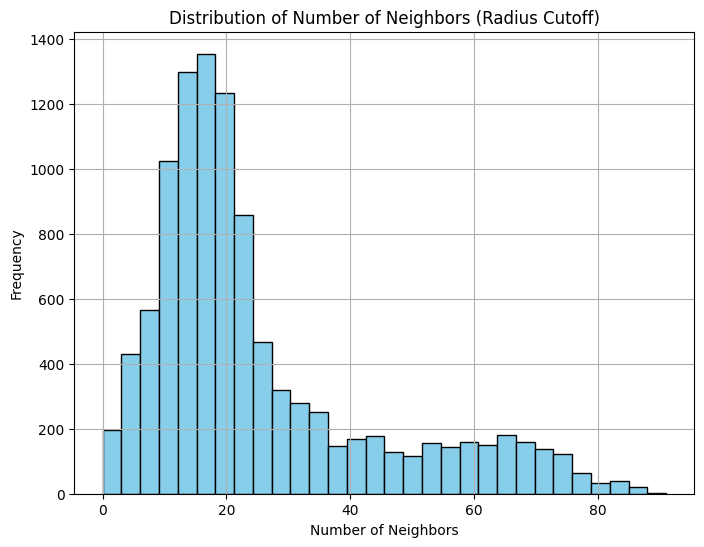

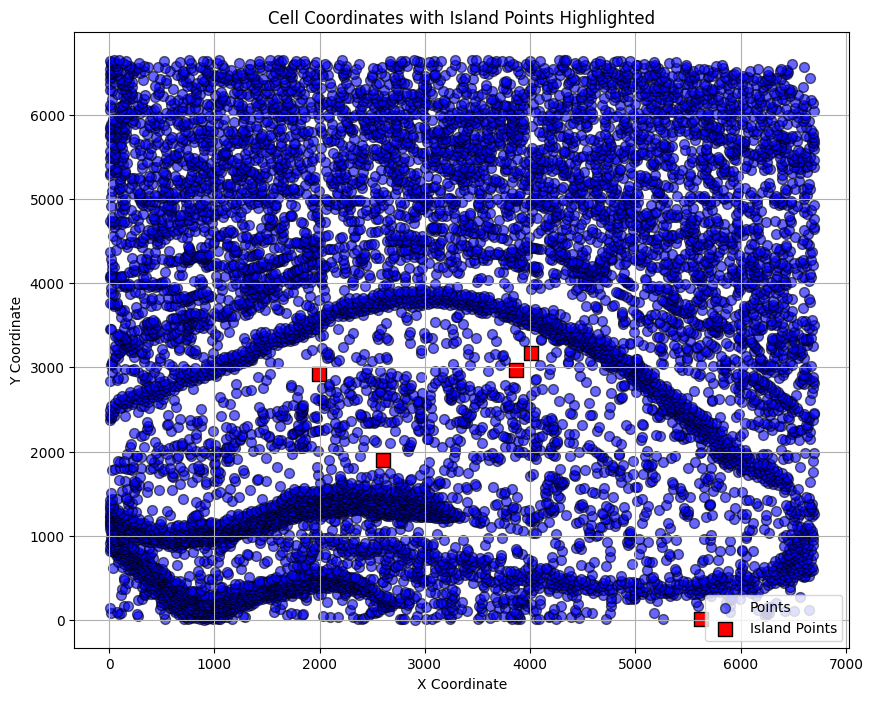

Number of island points: 5
Island point indices: [  10 3425 4504 4549 4785]


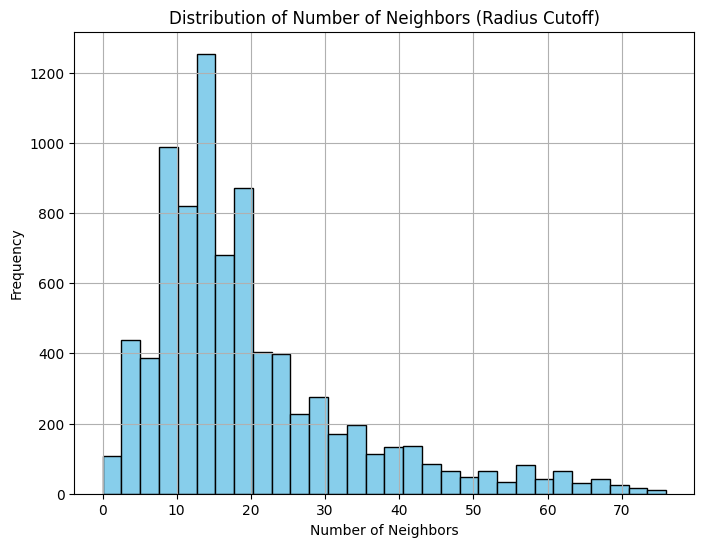

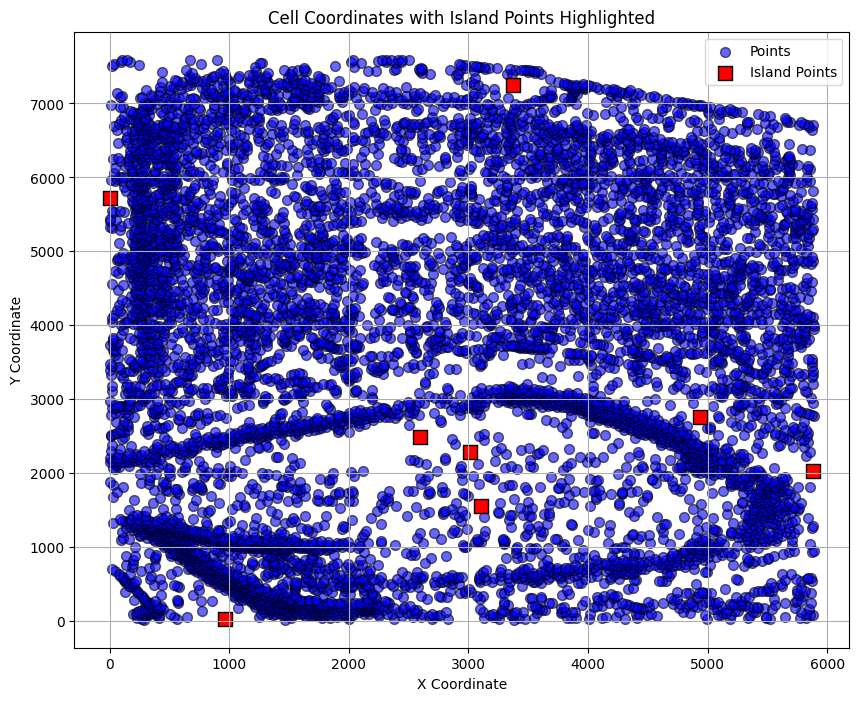

Number of island points: 8
Island point indices: [  18 1924 2222 2409 2557 2862 6377 8043]


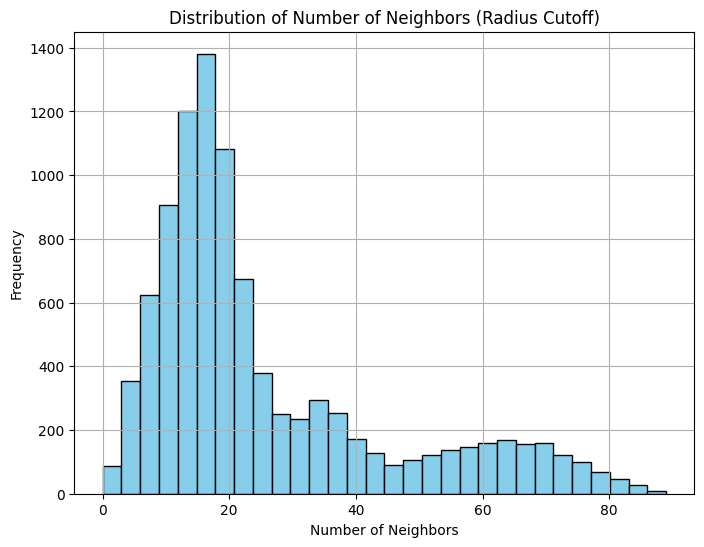

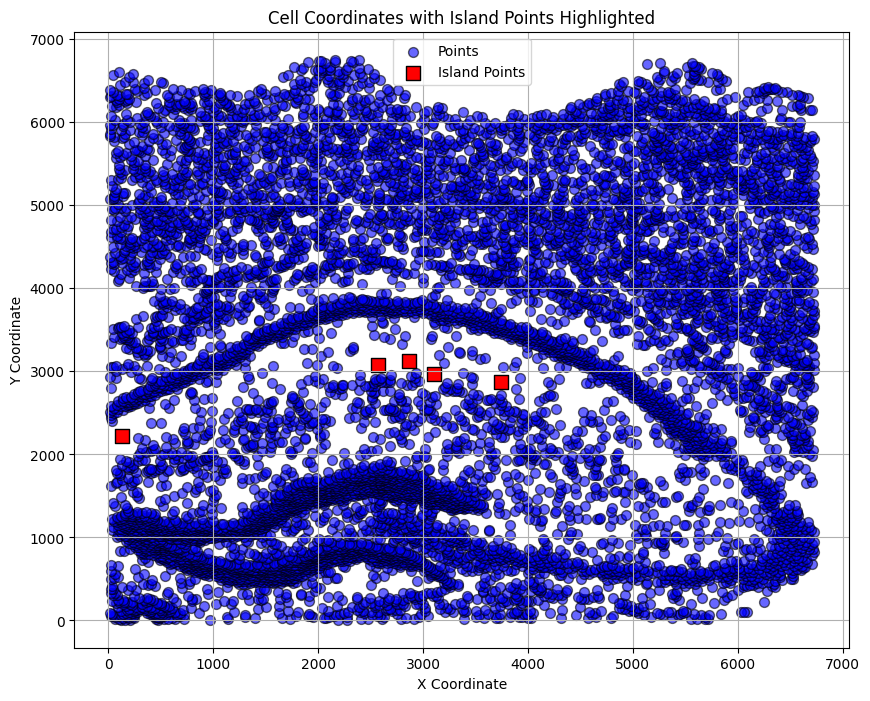

Number of island points: 5
Island point indices: [3815 4489 4600 4719 4759]
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0


In [22]:
# Extract spatial coordinates for each cell
cell_coords = {}
for key in adatas.keys():
    cell_coords[key] = adatas[key].obsm["spatial"].copy()
neighbors = {}
for key in cell_coords.keys():
    neighbors[key] = construct_affinity_matrix(cell_coords[key], mode="radius", cutoff=150)

# Load the plaque dataset
img_dir = "/public/home/jijh/st_project/cellbin_analysis/spatial_variation/wx_data/protein_seg_result/"
img_files = os.listdir(img_dir)
img_files = [i for i in img_files if i.endswith(".tiff") and "plaque" in i]
# Read the images

imgs = {}
for i in range(len(img_files)):
    imgs[img_files[i].split(".")[0]] = io.imread(os.path.join(img_dir, img_files[i]))
imgs.keys()
# Rename the imgs to match the adata keys
for key in list(imgs.keys()):
    parts = key.split("_")
    if len(parts) > 1:
        new_key = parts[1] + "_" + parts[2]
        imgs[new_key] = imgs.pop(key)


# Extract patches from the images
patches = {}
for key in imgs.keys():
    patches[key] = extract_patches(imgs[key], cell_coords[key], patch_size=128)

# Convert the patches to binary and calculate the area of positive pixels for each patch
binary_patches = {}
for key in patches.keys():
    binary_patches[key] = [patch > 0 for patch in patches[key]]
# Calculate the area of positive pixels for each patch
areas = {}
for key in binary_patches.keys():
    areas[key] = [np.sum(patch) for patch in binary_patches[key]]

In [8]:
# Create the graph dictionary
graph_data_dict = create_graph_data_dict(adatas, areas, neighbors, cell_coords, embeddings=["X"])


# Efficiently convert patches to tensors in batch
for key, graph in tqdm(graph_data_dict.items(), desc="Adding patches to graph data"):
    # Ensure patches[key] is a list of NumPy arrays
    patches_tensor = torch.tensor(np.array(patches[key]), dtype=torch.float)  # Convert patches to a single tensor efficiently
    graph.patches = patches_tensor
# Normalize the edge_attr
for key, graph in tqdm(graph_data_dict.items(), desc="Normalizing edge_attr"):
    graph.edge_attr = graph.edge_attr / graph.edge_attr.max()

Normalizing edge_attr: 100%|██████████| 4/4 [00:00<00:00, 3943.87it/s]


# STAGATE Mordern


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv


class STAGATE(nn.Module):
    r"""
    A simple autoencoder-like GAT architecture using PyG's GATConv.
    
    Architecture:
      - Encoder: 2 GAT layers
      - Decoder: 2 GAT layers (mirroring)
    
    Parameters
    ----------
    in_channels : int
        Input feature dimension.
    hidden_channels : int
        Hidden dimension in the encoder/decoder intermediate layers.
    out_channels : int
        Bottleneck (latent) dimension in the middle of the network.
    """
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super().__init__()
        # Encoder:
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=False)
        self.conv2 = GATConv(hidden_channels, out_channels, heads=4, concat=False)
        # Decoder:
        self.conv3 = GATConv(out_channels, hidden_channels, heads=4, concat=False)
        self.conv4 = GATConv(hidden_channels, in_channels, heads=4, concat=False)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor):
        """
        Forward pass of the STAGATE model.
        
        Returns:
        --------
        (z, out) where
          - z is the latent representation after the encoder (conv2).
          - out is the reconstructed features after the decoder (conv4).
        """
        # ----- Encoder -----
        h1 = F.elu(self.conv1(x, edge_index))     # [num_nodes, hidden_channels]
        z  = self.conv2(h1, edge_index)           # [num_nodes, out_channels] (latent)
        
        # ----- Decoder -----
        h3 = F.elu(self.conv3(z, edge_index))      # [num_nodes, hidden_channels]
        out = self.conv4(h3, edge_index)           # [num_nodes, in_channels] (reconstructed)
        
        return z, out


In [48]:
import torch
import torch.nn.functional as F

def train_stagate_on_graph(
    graph,
    hidden_dims=[512, 30],
    n_epochs=500,
    lr=1e-3,
    weight_decay=1e-4,
    device=None
):
    """
    在给定的 Graph 上训练 STAGATE，输出 (model, latent_z)。
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    graph = graph.to(device)
    
    in_channels = graph.x.shape[1]
    hidden_channels, out_channels = hidden_dims  # hidden_dims=[512, 30]
    
    # 使用你修改后的 STAGATE（包含对称结构和 tied_attention）
    model = STAGATE(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # ---- 训练循环 ----
    model.train()
    for epoch in range(1, n_epochs+1):
        optimizer.zero_grad()
        
        # 前向传播
        z, out = model(graph.x, graph.edge_index)
        
        # 与官方一致，使用 MSE 做重构损失
        loss = F.mse_loss(out, graph.x)
        
        loss.backward()
        
        # 如果想与官方保持一致，可以加个 grad_clip=5.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        
        optimizer.step()
        
        if (epoch % 50 == 0) or (epoch == n_epochs):
            print(f"Epoch {epoch:03d}, Loss: {loss.item():.4f}")
    
    # 最后 eval 拿到 latent
    model.eval()
    with torch.no_grad():
        z, out = model(graph.x, graph.edge_index)
    z = z.cpu().numpy()
    
    return model, z


In [43]:
import scanpy as sc
import matplotlib.pyplot as plt

def save_latent_and_cluster(
    adata, 
    latent_z, 
    rep_key='X_stagate', 
    leiden_resolution=1.0, 
    cluster_key='leiden',
    spot_size=30  # 添加这个参数，用于绘图
):
    """
    将 latent 表征保存到 AnnData，并利用 Scanpy 的 neighbors 和 leiden 进行聚类，
    最后在空间坐标上可视化聚类结果。
    """
    # 1. 保存 latent 表征到 adata.obsm
    adata.obsm[rep_key] = latent_z
    
    # 2. 计算邻居图（基于 latent 表征）
    sc.pp.neighbors(adata, use_rep=rep_key)
    
    # 3. 使用 Leiden 算法进行聚类
    sc.tl.leiden(adata, resolution=leiden_resolution)
    
    # 4. 可视化：
    # 如果 adata.uns 中没有 spatial 图像信息，则需要提供 spot_size 参数
    if "spatial" in adata.obsm.keys():
        sc.pl.spatial(adata, color=cluster_key, title="Leiden Clustering", spot_size=spot_size)
    else:
        # 若没有空间图像数据，则也可以用 matplotlib 手动绘制，假设 adata.obsm['spatial'] 中有二维坐标
        if "spatial" in adata.obsm:
            coords = adata.obsm["spatial"]
            plt.figure(figsize=(6, 5))
            plt.scatter(coords[:, 0], coords[:, 1], c=adata.obs[cluster_key].cat.codes, cmap='tab20', s=spot_size)
            plt.gca().invert_yaxis()
            plt.title("Leiden Clustering")
            plt.colorbar()
            plt.legend(False)
            plt.show()
        else:
            print("adata 中既没有 spatial 图像信息，也没有 spatial 坐标，无法进行空间可视化。")


In [44]:
graph_data_dict.keys()

dict_keys(['8months-disease-replicate_1', '13months-disease-replicate_1', '8months-disease-replicate_2', '13months-disease-replicate_2'])

In [45]:
adata

AnnData object with n_obs × n_vars = 8186 × 2766
    obs: 'X_x', 'Y_x', 'X-scaled', 'Y-scaled', 'label', 'top_level_cell_type_x', 'sub_level_cell_type_x', 'dist', 'X_y', 'Y_y', 'top_level_cell_type_y', 'sub_level_cell_type_y', 'umap_x', 'umap_y', 'log_dist', 'celltype', 'chat_dist', 'Astro_dist', 'LHb_dist', 'CTX-Ex_dist', 'Oligo_dist', 'Micro_dist', 'OPC_dist', 'Inh_dist', 'SMC_dist', 'Endo_dist', 'ChN_dist', 'DG_dist', 'CA3_dist', 'CA2_dist', 'CA1_dist', 'fine', 'Astro1_dist', 'CTX-Ex2_dist', 'Oligo1_dist', 'Micro1_dist', 'Micro2_dist', 'Pvalb_Nog_dist', 'Astro3_dist', 'CTX-Ex3_dist', 'S5_dist', 'Oligo2_dist', 'Vip_dist', 'Lamp5_dist', 'Micro3_dist', 'Endo1_dist', 'Pvalb_dist', 'S3_dist', 'S4_dist', 'S2_dist', 'Oligo3_dist', 'Endo2_dist', 'S1_dist', 'Endo3_dist', 'Sst_dist', 'Astro2_dist', 'CA3-Ex_dist', 'CA2-Ex_dist', 'CA1-Ex_dist', 'Cnr1_dist', 'CTX-Ex4_dist', 'CTX-Ex1_dist', 'leiden'
    var: 'gene_name', 'mean', 'std'
    uns: 'celltype_colors', 'top_level_cell_type_x_colors', 'l

In [46]:
# 选择需要处理的 key
my_key = "8months-disease-replicate_1"  # 根据您实际的 key 进行调整
graph = graph_data_dict[my_key].clone()   # PyG Data 对象
adata = adatas[my_key].copy()             # 对应的 AnnData 对象

# 训练 STAGATE 模型，获取 latent 表征
model, latent_z = train_stagate_on_graph(
    graph,
    hidden_dims=[512, 30],  # 例如 512 个 hidden 单元，latent 维度 30
    n_epochs=1000,           # 根据实际情况调整 epoch 数
    lr=1e-3,
    weight_decay=1e-4
)

# 将 latent 表征写入 adata，并用 Leiden 进行聚类和可视化
save_latent_and_cluster(
    adata,
    latent_z,
    rep_key='X_stagate',      # latent 表征保存的键，可根据需要调整
    leiden_resolution=0.1,      # 聚类分辨率
    cluster_key='leiden'        # 默认 Leiden 产生的聚类结果存在 adata.obs['leiden']
)


Using device: cuda:0


TypeError: GATConv.forward() got an unexpected keyword argument 'attention'

In [ ]:
torch.cuda.empty_cache()

# 新的trial

In [50]:

#######################################################################
# 1) Necessary imports
#######################################################################
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
from tqdm import tqdm

# PyTorch Geometric imports
from torch_geometric.data import Data
from torch_geometric.utils import coalesce

# For random seeds
import random
import scanpy as sc

#######################################################################
# 2) Your custom function to construct the adjacency matrix
#    (Affinity Matrix) using radius or number-of-neighbors logic.
#    We'll re-use your function verbatim.
#######################################################################
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors, radius_neighbors_graph
from scipy.sparse import csr_matrix

def construct_affinity_matrix(
    coordinates,
    mode='radius',
    cutoff=1.0,
    n_neighbors=5,
    metric='euclidean'
):
    """
    Constructs a neighbors affinity matrix based on either radius cutoff
    or number of neighbors, returning a CSR adjacency matrix.

    Parameters:
    - coordinates: (N, 2) array of cell coordinates.
    - mode: 'radius' or 'number' to choose the cutoff method.
    - cutoff: radius value if mode='radius'.
    - n_neighbors: number of neighbors if mode='number'.
    - metric: distance metric to use.

    Returns:
    - affinity_matrix: (N, N) sparse matrix with inverse distance weights.
      (Note that you can treat it as adjacency for PyG.)
    """
    N = coordinates.shape[0]

    if mode == 'radius':
        # Use radius_neighbors_graph to get adjacency based on radius
        adjacency = radius_neighbors_graph(
            coordinates, radius=cutoff, mode='connectivity',
            metric=metric, include_self=False
        )

        # Also get distances to fill data=1/dist
        nbrs = NearestNeighbors(radius=cutoff, metric=metric)
        nbrs.fit(coordinates)
        distances_list, indices_list = nbrs.radius_neighbors(coordinates, return_distance=True)

        row = []
        col = []
        data = []
        for i in range(N):
            neighbors_i = indices_list[i]
            dists_i = distances_list[i]
            for j, dist in zip(neighbors_i, dists_i):
                if dist > 0:  # avoid division by zero
                    row.append(i)
                    col.append(j)
                    data.append(1.0 / dist)
        affinity_matrix = csr_matrix((data, (row, col)), shape=(N, N))

    elif mode == 'number':
        if n_neighbors < 0:
            raise ValueError("Number of neighbors must be non-negative.")
        elif n_neighbors == 0:
            # all points are isolated
            affinity_matrix = csr_matrix((N, N), dtype=float)
            return affinity_matrix

        # Use NearestNeighbors to get fixed number of neighbors
        nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, metric=metric)
        nbrs.fit(coordinates)
        distances, indices = nbrs.kneighbors(coordinates)

        # Exclude self-neighbor
        distances = distances[:, 1:]
        indices = indices[:, 1:]

        row = np.repeat(np.arange(N), n_neighbors)
        col = indices.flatten()
        inv_dists = 1.0 / distances.flatten()
        # Replace infinite or NaN with 0
        inv_dists[~np.isfinite(inv_dists)] = 0
        data = inv_dists
        affinity_matrix = csr_matrix((data, (row, col)), shape=(N, N))
    else:
        raise ValueError("Mode must be 'radius' or 'number'")

    return affinity_matrix


#######################################################################
# 3) Construct a PyG Data object from your adata.
#    This is analogous to STAGATE's "Transfer_pytorch_Data" function.
#######################################################################
def adata_to_pyg_data(adata, adjacency_csr):
    """
    Convert an AnnData object plus a CSR adjacency to a PyG Data object.
    - adata.X is the features
    - adjacency_csr is the NxN adjacency in CSR format
    """
    # If adata.X is a sparse matrix, make it dense or a float tensor
    if sp.issparse(adata.X):
        x_features = torch.FloatTensor(adata.X.todense())
    else:
        x_features = torch.FloatTensor(adata.X)

    # Row and column of adjacency
    row, col = adjacency_csr.nonzero()
    # coalesce (row,col) if needed
    edge_index = torch.LongTensor(np.stack([row, col], axis=0))
    edge_index = coalesce(edge_index, num_nodes=adata.n_obs)

    data_pyg = Data(x=x_features, edge_index=edge_index)
    return data_pyg

#######################################################################
# 4) Define a GATConv layer that matches the STAGATE approach.
#    (Below is a simplified GAT implementation in PyG style.)
#######################################################################
from torch_geometric.nn import GATConv as PyGGATConv

#######################################################################
# 5) Define the STAGATE-like autoencoder using PyG GATConvs
#    This is a 4-layer symmetrical autoencoder:
#    conv1 -> conv2 -> conv3 -> conv4
#######################################################################
class STAGATE_AE(nn.Module):
    def __init__(self, in_dim, hidden_dim=512, out_dim=30):
        super(STAGATE_AE, self).__init__()
        """
        A 4-layer symmetrical autoencoder using GATConv:
          conv1: (in_dim -> hidden_dim)
          conv2: (hidden_dim -> out_dim)
          conv3: (out_dim -> hidden_dim)
          conv4: (hidden_dim -> in_dim)
        """
        self.conv1 = PyGGATConv(in_channels=in_dim, out_channels=hidden_dim, heads=1, concat=False, dropout=0.0, add_self_loops=False)
        self.conv2 = PyGGATConv(in_channels=hidden_dim, out_channels=out_dim, heads=1, concat=False, dropout=0.0, add_self_loops=False)
        # Decoding layers
        self.conv3 = PyGGATConv(in_channels=out_dim, out_channels=hidden_dim, heads=1, concat=False, dropout=0.0, add_self_loops=False)
        self.conv4 = PyGGATConv(in_channels=hidden_dim, out_channels=in_dim, heads=1, concat=False, dropout=0.0, add_self_loops=False)

    def forward(self, x, edge_index):
        # 1) Encoder
        h1 = F.elu(self.conv1(x, edge_index))
        h2 = self.conv2(h1, edge_index)

        # 2) Decoder
        #    In official STAGATE, they do some tying of weights or attention.
        #    Here, we'll keep it straightforward.
        h3 = F.elu(self.conv3(h2, edge_index))
        h4 = self.conv4(h3, edge_index)

        return h2, h4  # h2 is the latent, h4 is the reconstructed x

#######################################################################
# 6) Training function, analogous to train_STAGATE
#######################################################################
def train_STAGATE(
    adata,
    hidden_dim=512,
    out_dim=30,
    n_epochs=1000,
    lr=1e-3,
    weight_decay=1e-4,
    device='cuda',
    key_added='STAGATE'
):
    """
    Trains a 4-layer GAT-based autoencoder on adata.X + adjacency
    and saves the embedding in adata.obsm[key_added].
    """
    # 6.1) Prepare adjacency from adata.obsm['spatial'] via your function
    coords = adata.obsm['spatial']  # shape [N, 2]
    # Example: use radius mode with cutoff=100 or etc. 
    # Adjust the cutoff or n_neighbors for your data scale.
    # For demonstration, let's do n_neighbors=10
    adjacency_csr = construct_affinity_matrix(
        coords,
        mode='number',  
        n_neighbors=10,  # <-- Adjust as needed
    )

    # 6.2) Build the PyG Data object
    data_pyg = adata_to_pyg_data(adata, adjacency_csr)
    data_pyg = data_pyg.to(device)

    # 6.3) Define the model
    in_dim = data_pyg.x.shape[1]
    model = STAGATE_AE(in_dim, hidden_dim=hidden_dim, out_dim=out_dim).to(device)

    # 6.4) Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # 6.5) Training loop
    model.train()
    for epoch in tqdm(range(1, n_epochs+1)):
        optimizer.zero_grad()
        z, x_recon = model(data_pyg.x, data_pyg.edge_index)
        # reconstruction loss
        loss = F.mse_loss(x_recon, data_pyg.x)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        if epoch % 200 == 0:
            print(f"Epoch {epoch}, loss={loss.item():.4f}")

    # 6.6) Final embedding
    model.eval()
    with torch.no_grad():
        z, x_recon = model(data_pyg.x, data_pyg.edge_index)
    # store the latent in adata.obsm
    adata.obsm[key_added] = z.cpu().numpy()

    return adata

#######################################################################
# 7) DEMO USAGE
#    In practice, you will load or have your own adata, 
#    with adata.X and adata.obsm['spatial'] available.
#    For demonstration, let's build a random adata with random features 
#    and random coordinates.
#######################################################################
import anndata

# # Suppose we have 1000 cells, each with 200 features
# n_cells = 1000
# n_genes = 200
# np.random.seed(0)
# X = np.random.rand(n_cells, n_genes).astype(np.float32)

# # Fake 2D coordinates (like spatial coords)
# spatial_coords = np.random.rand(n_cells, 2) * 100.0  # scale to e.g. [0,100]

# Build AnnData
adata_demo = adatas['13months-disease-replicate_1'].copy()

# We can run the training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_adata = train_STAGATE(
    adata_demo,
    hidden_dim=64,  # smaller hidden for demonstration
    out_dim=16,
    n_epochs=1000,
    lr=1e-3,
    weight_decay=1e-4,
    device=device,
    key_added='STAGATE'
)

print("Done training. The learned embedding is in trained_adata.obsm['STAGATE']. Shape:")
print(trained_adata.obsm['STAGATE'].shape)


 21%|██        | 211/1000 [00:03<00:13, 60.16it/s]

Epoch 200, loss=0.9507


 41%|████      | 410/1000 [00:07<00:09, 61.34it/s]

Epoch 400, loss=0.9465


 61%|██████    | 610/1000 [00:10<00:06, 60.89it/s]

Epoch 600, loss=0.9453


 81%|████████  | 810/1000 [00:13<00:03, 61.11it/s]

Epoch 800, loss=0.9448


100%|██████████| 1000/1000 [00:17<00:00, 58.34it/s]

Epoch 1000, loss=0.9445
Done training. The learned embedding is in trained_adata.obsm['STAGATE']. Shape:
(10372, 16)


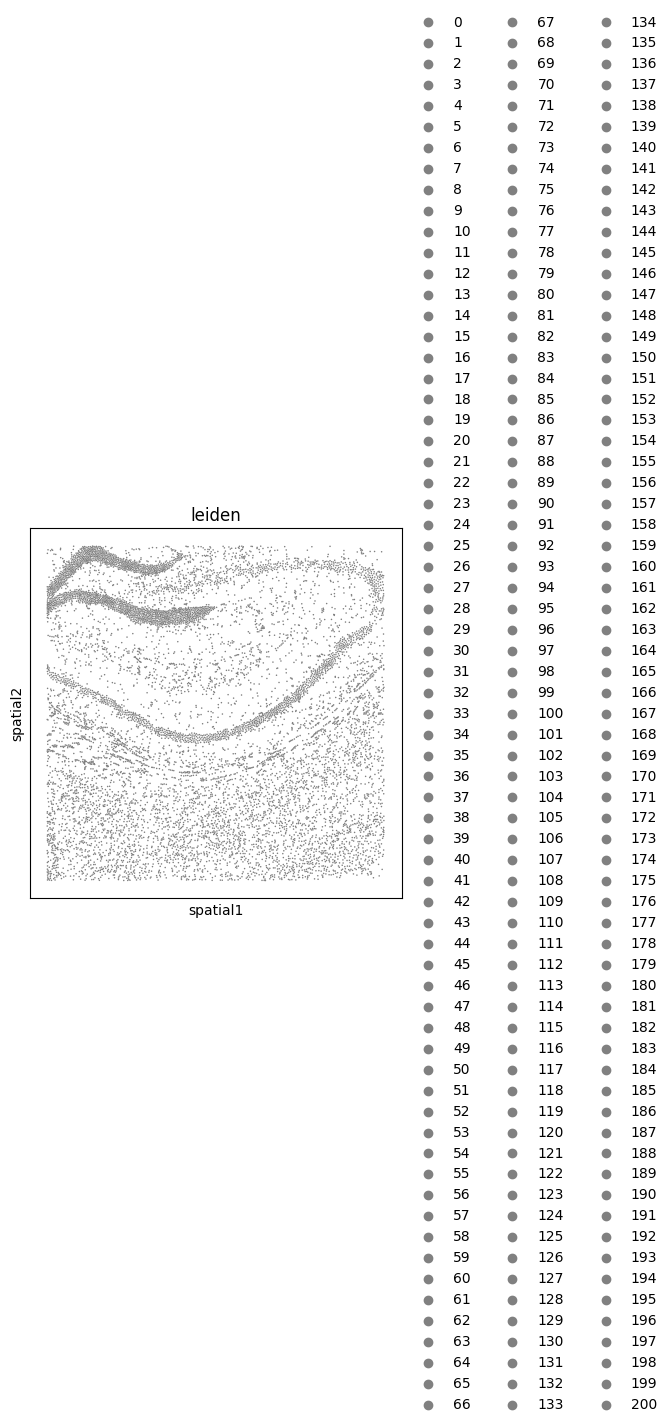

In [54]:
sc.pp.neighbors(trained_adata, use_rep='STAGATE')
sc.tl.leiden(trained_adata, resolution=0.1)
sc.pl.spatial(trained_adata, color='leiden', spot_size=30)

# 原版

In [6]:
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter
import torch.nn as nn
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax



class GATConv(MessagePassing):
    r"""The graph attentional operator from the `"Graph Attention Networks"
    <https://arxiv.org/abs/1710.10903>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \alpha_{i,i}\mathbf{\Theta}\mathbf{x}_{i} +
        \sum_{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}_{j},

    where the attention coefficients :math:`\alpha_{i,j}` are computed as

    .. math::
        \alpha_{i,j} =
        \frac{
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_j]
        \right)\right)}
        {\sum_{k \in \mathcal{N}(i) \cup \{ i \}}
        \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
        [\mathbf{\Theta}\mathbf{x}_i \, \Vert \, \mathbf{\Theta}\mathbf{x}_k]
        \right)\right)}.

    Args:
        in_channels (int or tuple): Size of each input sample, or :obj:`-1` to
            derive the size from the first input(s) to the forward method.
            A tuple corresponds to the sizes of source and target
            dimensionalities.
        out_channels (int): Size of each output sample.
        heads (int, optional): Number of multi-head-attentions.
            (default: :obj:`1`)
        concat (bool, optional): If set to :obj:`False`, the multi-head
            attentions are averaged instead of concatenated.
            (default: :obj:`True`)
        negative_slope (float, optional): LeakyReLU angle of the negative
            slope. (default: :obj:`0.2`)
        dropout (float, optional): Dropout probability of the normalized
            attention coefficients which exposes each node to a stochastically
            sampled neighborhood during training. (default: :obj:`0`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    _alpha: OptTensor

    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, heads: int = 1, concat: bool = True,
                 negative_slope: float = 0.2, dropout: float = 0.0,
                 add_self_loops: bool = True, bias: bool = True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(GATConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops

        # In case we are operating in bipartite graphs, we apply separate
        # transformations 'lin_src' and 'lin_dst' to source and target nodes:
        # if isinstance(in_channels, int):
        #     self.lin_src = Linear(in_channels, heads * out_channels,
        #                           bias=False, weight_initializer='glorot')
        #     self.lin_dst = self.lin_src
        # else:
        #     self.lin_src = Linear(in_channels[0], heads * out_channels, False,
        #                           weight_initializer='glorot')
        #     self.lin_dst = Linear(in_channels[1], heads * out_channels, False,
        #                           weight_initializer='glorot')

        self.lin_src = nn.Parameter(torch.zeros(size=(in_channels, out_channels)))
        nn.init.xavier_normal_(self.lin_src.data, gain=1.414)
        self.lin_dst = self.lin_src


        # The learnable parameters to compute attention coefficients:
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))
        nn.init.xavier_normal_(self.att_src.data, gain=1.414)
        nn.init.xavier_normal_(self.att_dst.data, gain=1.414)

        # if bias and concat:
        #     self.bias = Parameter(torch.Tensor(heads * out_channels))
        # elif bias and not concat:
        #     self.bias = Parameter(torch.Tensor(out_channels))
        # else:
        #     self.register_parameter('bias', None)

        self._alpha = None
        self.attentions = None

        # self.reset_parameters()

    # def reset_parameters(self):
    #     self.lin_src.reset_parameters()
    #     self.lin_dst.reset_parameters()
    #     glorot(self.att_src)
    #     glorot(self.att_dst)
    #     # zeros(self.bias)

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                size: Size = None, return_attention_weights=None, attention=True, tied_attention = None):
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], Tensor, Size, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, Size, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels

        # We first transform the input node features. If a tuple is passed, we
        # transform source and target node features via separate weights:
        if isinstance(x, Tensor):
            assert x.dim() == 2, "Static graphs not supported in 'GATConv'"
            # x_src = x_dst = self.lin_src(x).view(-1, H, C)
            x_src = x_dst = torch.mm(x, self.lin_src).view(-1, H, C)
        else:  # Tuple of source and target node features:
            x_src, x_dst = x
            assert x_src.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = self.lin_src(x_src).view(-1, H, C)
            if x_dst is not None:
                x_dst = self.lin_dst(x_dst).view(-1, H, C)

        x = (x_src, x_dst)

        if not attention:
            return x[0].mean(dim=1)
            # return x[0].view(-1, self.heads * self.out_channels)

        if tied_attention == None:
            # Next, we compute node-level attention coefficients, both for source
            # and target nodes (if present):
            alpha_src = (x_src * self.att_src).sum(dim=-1)
            alpha_dst = None if x_dst is None else (x_dst * self.att_dst).sum(-1)
            alpha = (alpha_src, alpha_dst)
            self.attentions = alpha
        else:
            alpha = tied_attention


        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                # We only want to add self-loops for nodes that appear both as
                # source and target nodes:
                num_nodes = x_src.size(0)
                if x_dst is not None:
                    num_nodes = min(num_nodes, x_dst.size(0))
                num_nodes = min(size) if size is not None else num_nodes
                edge_index, _ = remove_self_loops(edge_index)
                edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                edge_index = set_diag(edge_index)

        # propagate_type: (x: OptPairTensor, alpha: OptPairTensor)
        out = self.propagate(edge_index, x=x, alpha=alpha, size=size)

        alpha = self._alpha
        assert alpha is not None
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        # if self.bias is not None:
        #     out += self.bias

        if isinstance(return_attention_weights, bool):
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, x_j: Tensor, alpha_j: Tensor, alpha_i: OptTensor,
                index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        # Given egel-level attention coefficients for source and target nodes,
        # we simply need to sum them up to "emulate" concatenation:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        #alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = torch.sigmoid(alpha)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha  # Save for later use.
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)

    def __repr__(self):
        return '{}({}, {}, heads={})'.format(self.__class__.__name__,
                                             self.in_channels,
                                             self.out_channels, self.heads)




In [7]:
import pandas as pd
import numpy as np
import sklearn.neighbors
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data

def Transfer_pytorch_Data(adata):
    G_df = adata.uns['Spatial_Net'].copy()
    cells = np.array(adata.obs_names)
    cells_id_tran = dict(zip(cells, range(cells.shape[0])))
    G_df['Cell1'] = G_df['Cell1'].map(cells_id_tran)
    G_df['Cell2'] = G_df['Cell2'].map(cells_id_tran)

    G = sp.coo_matrix((np.ones(G_df.shape[0]), (G_df['Cell1'], G_df['Cell2'])), shape=(adata.n_obs, adata.n_obs))
    G = G + sp.eye(G.shape[0])

    edgeList = np.nonzero(G)
    if type(adata.X) == np.ndarray:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X))  # .todense()
    else:
        data = Data(edge_index=torch.LongTensor(np.array(
            [edgeList[0], edgeList[1]])), x=torch.FloatTensor(adata.X.todense()))  # .todense()
    return data

def Batch_Data(adata, num_batch_x, num_batch_y, spatial_key=['X', 'Y'], plot_Stats=False):
    Sp_df = adata.obs.loc[:, spatial_key].copy()
    Sp_df = np.array(Sp_df)
    batch_x_coor = [np.percentile(Sp_df[:, 0], (1/num_batch_x)*x*100) for x in range(num_batch_x+1)]
    batch_y_coor = [np.percentile(Sp_df[:, 1], (1/num_batch_y)*x*100) for x in range(num_batch_y+1)]

    Batch_list = []
    for it_x in range(num_batch_x):
        for it_y in range(num_batch_y):
            min_x = batch_x_coor[it_x]
            max_x = batch_x_coor[it_x+1]
            min_y = batch_y_coor[it_y]
            max_y = batch_y_coor[it_y+1]
            temp_adata = adata.copy()
            temp_adata = temp_adata[temp_adata.obs[spatial_key[0]].map(lambda x: min_x <= x <= max_x)]
            temp_adata = temp_adata[temp_adata.obs[spatial_key[1]].map(lambda y: min_y <= y <= max_y)]
            Batch_list.append(temp_adata)
    if plot_Stats:
        f, ax = plt.subplots(figsize=(1, 3))
        plot_df = pd.DataFrame([x.shape[0] for x in Batch_list], columns=['#spot/batch'])
        sns.boxplot(y='#spot/batch', data=plot_df, ax=ax)
        sns.stripplot(y='#spot/batch', data=plot_df, ax=ax, color='red', size=5)
    return Batch_list

def Cal_Spatial_Net(adata, rad_cutoff=None, k_cutoff=None, model='Radius', verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff
        radius cutoff when model='Radius'
    k_cutoff
        The number of nearest neighbors when model='KNN'
    model
        The network construction model. When model=='Radius', the spot is connected to spots whose distance is less than rad_cutoff. When model=='KNN', the spot is connected to its first k_cutoff nearest neighbors.
    
    Returns
    -------
    The spatial networks are saved in adata.uns['Spatial_Net']
    """

    assert(model in ['Radius', 'KNN'])
    if verbose:
        print('------Calculating spatial graph...')
    coor = pd.DataFrame(adata.obsm['spatial'])
    coor.index = adata.obs.index
    coor.columns = ['imagerow', 'imagecol']

    if model == 'Radius':
        nbrs = sklearn.neighbors.NearestNeighbors(radius=rad_cutoff).fit(coor)
        distances, indices = nbrs.radius_neighbors(coor, return_distance=True)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices[it].shape[0], indices[it], distances[it])))
    
    if model == 'KNN':
        nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=k_cutoff+1).fit(coor)
        distances, indices = nbrs.kneighbors(coor)
        KNN_list = []
        for it in range(indices.shape[0]):
            KNN_list.append(pd.DataFrame(zip([it]*indices.shape[1],indices[it,:], distances[it,:])))

    KNN_df = pd.concat(KNN_list)
    KNN_df.columns = ['Cell1', 'Cell2', 'Distance']

    Spatial_Net = KNN_df.copy()
    Spatial_Net = Spatial_Net.loc[Spatial_Net['Distance']>0,]
    id_cell_trans = dict(zip(range(coor.shape[0]), np.array(coor.index), ))
    Spatial_Net['Cell1'] = Spatial_Net['Cell1'].map(id_cell_trans)
    Spatial_Net['Cell2'] = Spatial_Net['Cell2'].map(id_cell_trans)
    if verbose:
        print('The graph contains %d edges, %d cells.' %(Spatial_Net.shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %(Spatial_Net.shape[0]/adata.n_obs))

    adata.uns['Spatial_Net'] = Spatial_Net


def Cal_Spatial_Net_3D(adata, rad_cutoff_2D, rad_cutoff_Zaxis,
                       key_section='Section_id', section_order=None, verbose=True):
    """\
    Construct the spatial neighbor networks.

    Parameters
    ----------
    adata
        AnnData object of scanpy package.
    rad_cutoff_2D
        radius cutoff for 2D SNN construction.
    rad_cutoff_Zaxis
        radius cutoff for 2D SNN construction for consturcting SNNs between adjacent sections.
    key_section
        The columns names of section_ID in adata.obs.
    section_order
        The order of sections. The SNNs between adjacent sections are constructed according to this order.
    
    Returns
    -------
    The 3D spatial networks are saved in adata.uns['Spatial_Net'].
    """
    adata.uns['Spatial_Net_2D'] = pd.DataFrame()
    adata.uns['Spatial_Net_Zaxis'] = pd.DataFrame()
    num_section = np.unique(adata.obs[key_section]).shape[0]
    if verbose:
        print('Radius used for 2D SNN:', rad_cutoff_2D)
        print('Radius used for SNN between sections:', rad_cutoff_Zaxis)
    for temp_section in np.unique(adata.obs[key_section]):
        if verbose:
            print('------Calculating 2D SNN of section ', temp_section)
        temp_adata = adata[adata.obs[key_section] == temp_section, ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_2D, verbose=False)
        temp_adata.uns['Spatial_Net']['SNN'] = temp_section
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_2D'] = pd.concat(
            [adata.uns['Spatial_Net_2D'], temp_adata.uns['Spatial_Net']])
    for it in range(num_section-1):
        section_1 = section_order[it]
        section_2 = section_order[it+1]
        if verbose:
            print('------Calculating SNN between adjacent section %s and %s.' %
                  (section_1, section_2))
        Z_Net_ID = section_1+'-'+section_2
        temp_adata = adata[adata.obs[key_section].isin(
            [section_1, section_2]), ]
        Cal_Spatial_Net(
            temp_adata, rad_cutoff=rad_cutoff_Zaxis, verbose=False)
        spot_section_trans = dict(
            zip(temp_adata.obs.index, temp_adata.obs[key_section]))
        temp_adata.uns['Spatial_Net']['Section_id_1'] = temp_adata.uns['Spatial_Net']['Cell1'].map(
            spot_section_trans)
        temp_adata.uns['Spatial_Net']['Section_id_2'] = temp_adata.uns['Spatial_Net']['Cell2'].map(
            spot_section_trans)
        used_edge = temp_adata.uns['Spatial_Net'].apply(
            lambda x: x['Section_id_1'] != x['Section_id_2'], axis=1)
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[used_edge, ]
        temp_adata.uns['Spatial_Net'] = temp_adata.uns['Spatial_Net'].loc[:, [
            'Cell1', 'Cell2', 'Distance']]
        temp_adata.uns['Spatial_Net']['SNN'] = Z_Net_ID
        if verbose:
            print('This graph contains %d edges, %d cells.' %
                  (temp_adata.uns['Spatial_Net'].shape[0], temp_adata.n_obs))
            print('%.4f neighbors per cell on average.' %
                  (temp_adata.uns['Spatial_Net'].shape[0]/temp_adata.n_obs))
        adata.uns['Spatial_Net_Zaxis'] = pd.concat(
            [adata.uns['Spatial_Net_Zaxis'], temp_adata.uns['Spatial_Net']])
    adata.uns['Spatial_Net'] = pd.concat(
        [adata.uns['Spatial_Net_2D'], adata.uns['Spatial_Net_Zaxis']])
    if verbose:
        print('3D SNN contains %d edges, %d cells.' %
            (adata.uns['Spatial_Net'].shape[0], adata.n_obs))
        print('%.4f neighbors per cell on average.' %
            (adata.uns['Spatial_Net'].shape[0]/adata.n_obs))

def Stats_Spatial_Net(adata):
    import matplotlib.pyplot as plt
    Num_edge = adata.uns['Spatial_Net']['Cell1'].shape[0]
    Mean_edge = Num_edge/adata.shape[0]
    plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
    plot_df = plot_df/adata.shape[0]
    fig, ax = plt.subplots(figsize=[3,2])
    plt.ylabel('Percentage')
    plt.xlabel('')
    plt.title('Number of Neighbors (Mean=%.2f)'%Mean_edge)
    ax.bar(plot_df.index, plot_df)

def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    """\
    Clustering using the mclust algorithm.
    The parameters are the same as those in the R package mclust.
    """
    
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata


In [14]:
import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
cudnn.deterministic = True
cudnn.benchmark = True
import torch.nn.functional as F

class STAGATE(torch.nn.Module):
    def __init__(self, hidden_dims):
        super(STAGATE, self).__init__()

        [in_dim, num_hidden, out_dim] = hidden_dims
        self.conv1 = GATConv(in_dim, num_hidden, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv2 = GATConv(num_hidden, out_dim, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv3 = GATConv(out_dim, num_hidden, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)
        self.conv4 = GATConv(num_hidden, in_dim, heads=1, concat=False,
                             dropout=0, add_self_loops=False, bias=False)

    def forward(self, features, edge_index):

        h1 = F.elu(self.conv1(features, edge_index))
        h2 = self.conv2(h1, edge_index, attention=False)
        self.conv3.lin_src.data = self.conv2.lin_src.transpose(0, 1)
        self.conv3.lin_dst.data = self.conv2.lin_dst.transpose(0, 1)
        self.conv4.lin_src.data = self.conv1.lin_src.transpose(0, 1)
        self.conv4.lin_dst.data = self.conv1.lin_dst.transpose(0, 1)
        h3 = F.elu(self.conv3(h2, edge_index, attention=True,
                              tied_attention=self.conv1.attentions))
        h4 = self.conv4(h3, edge_index, attention=False)

        return h2, h4  # F.log_softmax(x, dim=-1)

In [24]:
adata = adatas['13months-disease-replicate_1'].copy()
Cal_Spatial_Net(adata, rad_cutoff=150)

------Calculating spatial graph...
The graph contains 263978 edges, 10372 cells.
25.4510 neighbors per cell on average.


In [25]:

data = Transfer_pytorch_Data(adata)

In [26]:
hidden_dims = [512, 30]

In [27]:
[data.x.shape[1]] + hidden_dims

[2766, 512, 30]

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = STAGATE(hidden_dims = [data.x.shape[1]] + hidden_dims).to(device)
data = data.to(device)

In [29]:
n_epochs = 100
lr = 0.001
weight_decay = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [30]:
from tqdm import tqdm
gradient_clipping = 5.0
key_added = 'STAGATE'
#loss_list = []
for epoch in tqdm(range(1, n_epochs+1)):
    model.train()
    optimizer.zero_grad()
    z, out = model(data.x, data.edge_index)
    loss = F.mse_loss(data.x, out) #F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    #loss_list.append(loss)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
    optimizer.step()

model.eval()
z, out = model(data.x, data.edge_index)

STAGATE_rep = z.to('cpu').detach().numpy()
adata.obsm[key_added] = STAGATE_rep


100%|██████████| 100/100 [00:01<00:00, 59.43it/s]


/tmp/ipykernel_86634/3241836177.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.1)


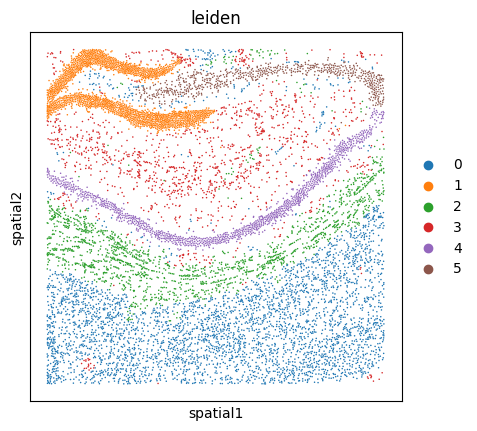

In [31]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.leiden(adata, resolution=0.1)
sc.pl.spatial(adata, color='leiden', spot_size=30)
